In [1]:
import jsonlines
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.font_manager import FontProperties
from party_list import random_list, alt_random
import numpy as np
from gerrytools.plotting import boxplot
from collections import defaultdict
import geopandas as gpd
from gerrychain.graph import Graph
import os

Switch axes...

Plots, more plots
8x5, 32x4, 10x4, 40x4 

100,000 Plans
- Warren/Dielh: SEN18D/R
- Baker(Republican): 2014/2018 GOV14/18/RD
- Markey/R: SEN20GEMAR/SEN20GKOCO
- Biden/Trump: PRES20GJBI/PRES20GDTR

Boxplot
- order districts from best republican plan to least, plot actual shares

Scatterplot
-  order districts from best republican plan to least, plot number of seats won

Plurality
- remake plots for 40 and 160 plans

In [2]:
ma = gpd.read_file('data/MA_vtd20/MA_vtd20.shp')

In [ ]:
ma_votes = ma[['SEN18D', 'SEN18R', 'GOV14D', 'GOV14R', 
            'GOV18D', 'GOV18R', 'SEN20GKOCO', 'SEN20GEMAR', 
            'PRES20GJBI', 'PRES20GDTR']].sum()



In [43]:
plans = []
with jsonlines.open('data/results/pl_ensembles-10.jsonl') as r:
    for line in r:
        plans.append(line)

In [44]:
#Sort plans by from least to greatest republican vote share
elections = ["SEN18", "GOV14", "GOV18", "SEN20", "PRES20"]
sorted_plans = []
for plan in plans:
    part = {election : None for election in elections}
    for election in elections:
        part[election] = sorted(plan[election], reverse=True)
    sorted_plans.append(part)

In [45]:
# generates list containing the party list results for reach election 
election_results = []
num_seats = 4
num_districts = 10

for election in elections:
    total_seats = {district : [] for district in range(num_districts)} 
    for plan in sorted_plans:
        results = alt_random(plan, num_seats)
        for district, d_results in results[election].items():
            cands, elected, party = d_results
            if party == 'Republican':
                total_seats[district].append(elected)
            elif party == 'Democrat':
                total_seats[district].append(num_seats-elected)
    
    election_results.append(total_seats)

len(election_results)

5

In [46]:
# compute statewide seats gained 
seats_per_election = []
num_plans = 100000

for results in election_results:
    state_seats = []
    for i in range(num_plans):
        seats = 0
        for dist in range(num_districts):
            seats += results[dist][i]
        state_seats.append(seats)
    seats_per_election.append(state_seats)

Make histograms for:
- STV
- Plurarlity 
- IRV
- Party List

for SEN18 partisan elections for 8 by 5, 32 by 5 (STV, Party Lists) 40 by 1 and 160 by 1 (IRV, Plurality)

percent of the ensemble on the y-axis 

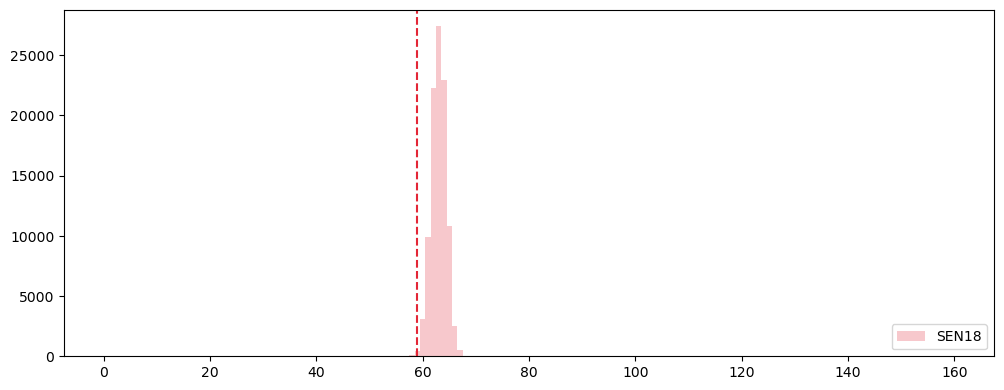

In [13]:
# Single elections
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4.5))
colors = ['#E32636', '#8B008B', '#FFBF00', '#8DB600', '#1560BD'] 
elections = ["SEN18", "GOV14", "GOV18", "SEN20", "PRES20"]
total_seats = num_seats * num_districts

ax.hist(seats_per_election[0], bins=list(range(0,total_seats)), color='#E32636', label='SEN18', alpha=0.25, align='right')
ax.axvline(int(total_seats*(ma_votes['SEN18R']/(ma_votes['SEN18D'] + ma_votes['SEN18R']))), color='#E32636', linestyle='dashed')
# ax.set_xlabel('Republican seats won statewide')
# ax.set_ylabel('Amount of plans')
ax.legend(loc="lower right")

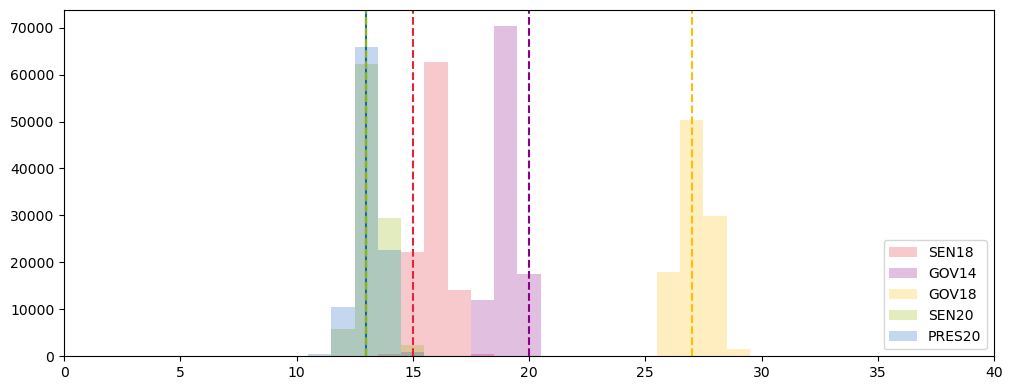

In [47]:
# All elections - add lines showing percentage share (republican vote share * 40)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4.5))
colors = ['#E32636', '#8B008B', '#FFBF00', '#8DB600', '#1560BD'] 
elections = ["SEN18", "GOV14", "GOV18", "SEN20", "PRES20"]
total_seats = num_seats * num_districts

for idx, seats in enumerate(seats_per_election):
    ax.hist(seats, bins=list(range(0, total_seats)), color=colors[idx], label=elections[idx], alpha=0.25, align='left')

# ax.set_xlabel('Republican seats won statewide')
# ax.set_ylabel('Frequency')

ax.axvline(round(total_seats*(ma_votes['PRES20GDTR']/(ma_votes['PRES20GDTR'] + ma_votes['PRES20GJBI']))), color='#1560BD', linestyle='dashed')

ax.axvline(round(total_seats*(ma_votes['PRES20GDTR']/(ma_votes['PRES20GDTR'] + ma_votes['PRES20GJBI']))), color='#1560BD')

ax.axvline(round(total_seats*(ma_votes['SEN18R']/(ma_votes['SEN18D'] + ma_votes['SEN18R']))), color='#E32636', linestyle='dashed')
ax.axvline(round(total_seats*(ma_votes['GOV14R']/(ma_votes['GOV14D'] + ma_votes['GOV14R']))), color='#8B008B', linestyle='dashed')
ax.axvline(round(total_seats*(ma_votes['GOV18R']/(ma_votes['GOV18D'] + ma_votes['GOV18R']))), color='#FFBF00', linestyle='dashed')
ax.axvline(round(total_seats*(ma_votes['SEN20GKOCO']/(ma_votes['SEN20GEMAR'] + ma_votes['SEN20GKOCO']))), color='#8DB600', linestyle='dashed')

ax.legend(loc="lower right")
ax.set_xlim(0, total_seats)

os.makedirs('./plots', exist_ok=True) 
plt.savefig(f'./plots/statewide-seats_{num_districts}x{num_seats}.png')

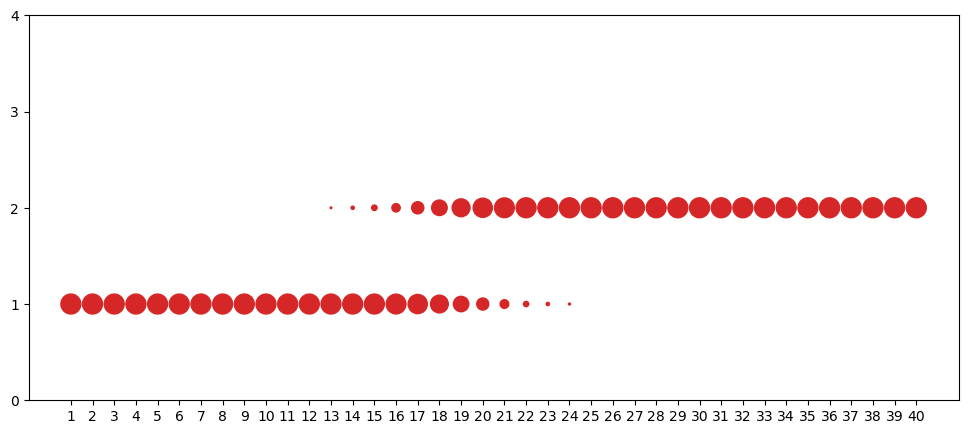

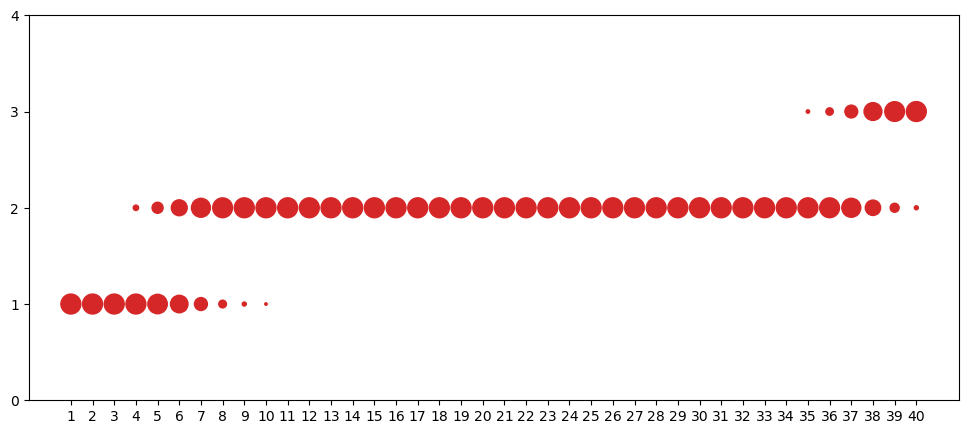

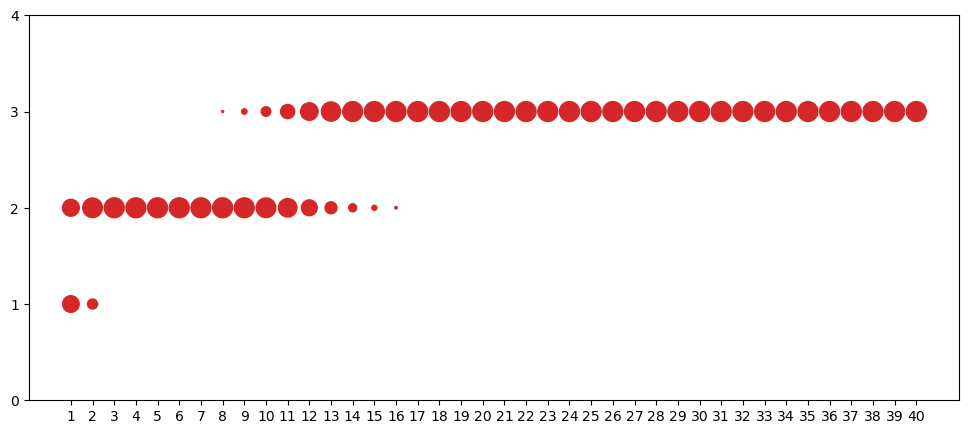

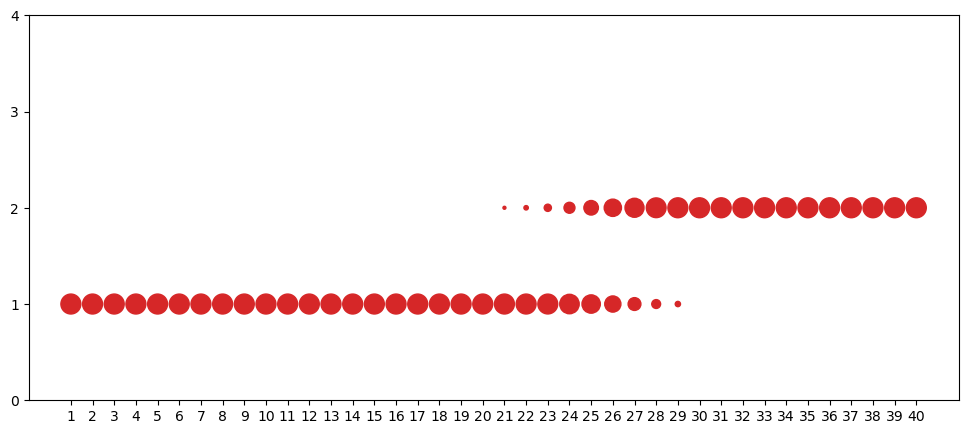

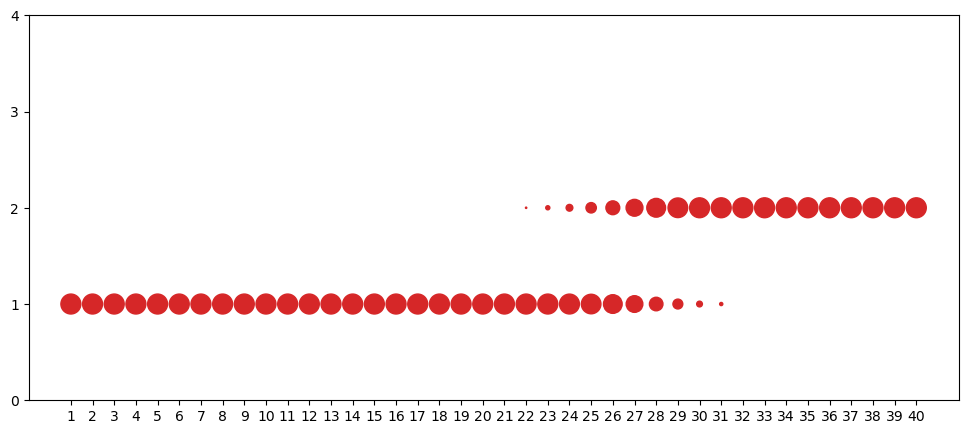

In [219]:
for idx, election in enumerate(elections):
    all_seats = []
    dist_lst = []
    for district, seats in election_results[idx].items():
        part = [district+1] * len(seats)
        all_seats += seats
        dist_lst += part

    data = np.column_stack((dist_lst, all_seats))
    unique, counts = np.unique(data, axis=0, return_counts=True)
    sizes = np.sqrt(counts) * 0.65
    plt.figure(figsize=(12, 5))
    plt.scatter(unique[:, 0], unique[:, 1], s=sizes, color = 'tab:red')
    # plt.ylim(0, 5)
    # plt.xlim(0, 11)
    plt.yticks(range(num_seats+1))
    plt.xticks(list(range(1,num_districts+1)))
    # plt.xlabel('Multi-member zones')
    # plt.ylabel('Republican seats won per zone')
    # plt.title(f'Frequency of seats won per zone ({election})')
    plt.savefig(f'./plots/seats-per-zone_{num_districts}x{num_seats}-{election}.png')
    

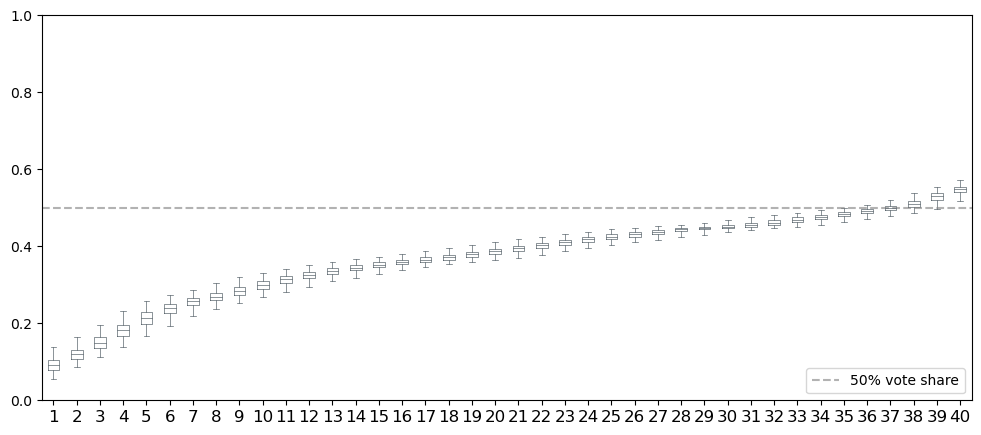

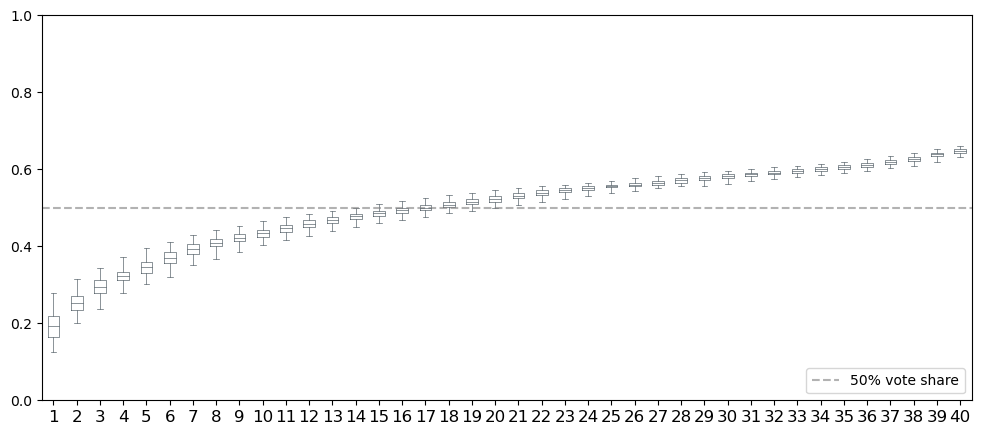

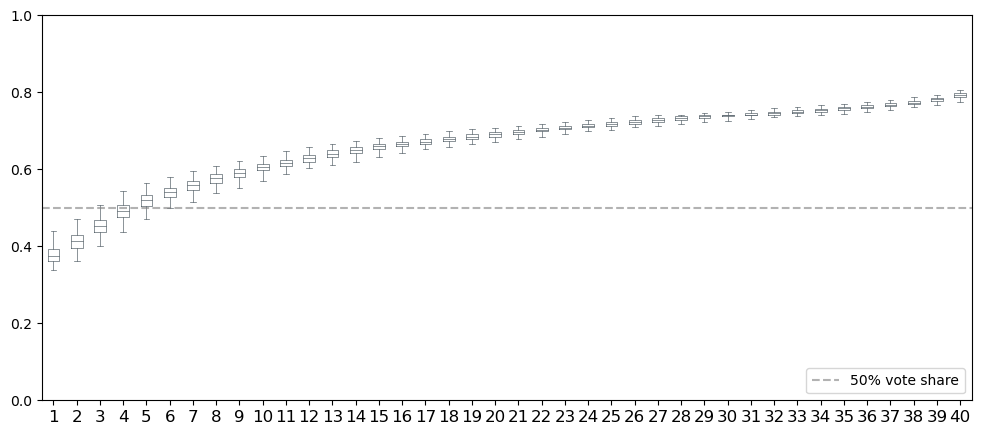

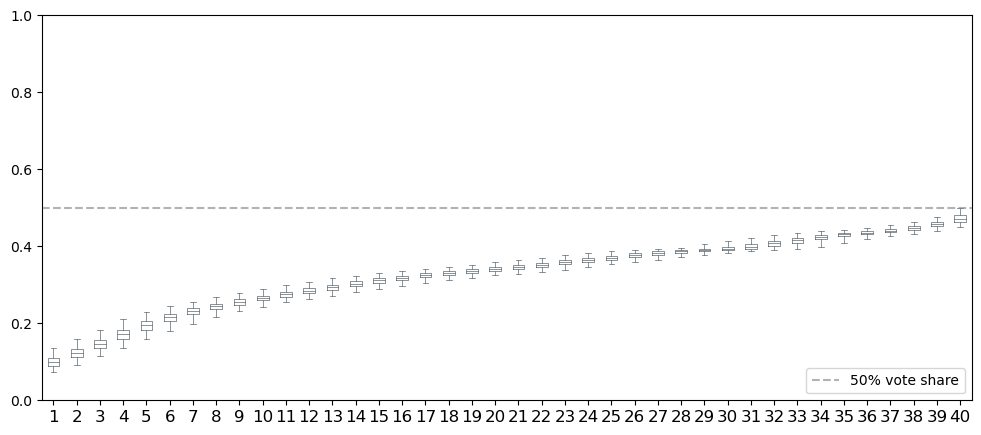

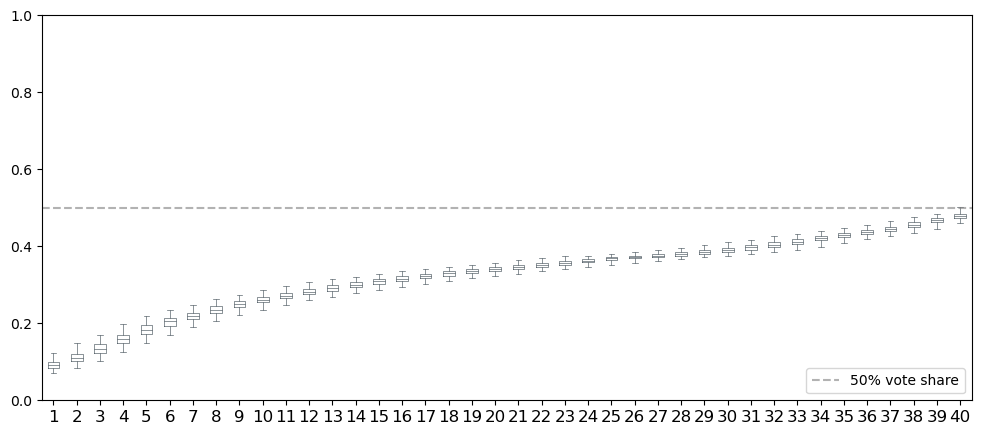

In [220]:
for election in elections:
    district_shares = {district : [] for district in range(num_districts)}

    for plan in sorted_plans:
        shares = plan[election]
        for idx, share in enumerate(shares):
            district_shares[idx].append(1-share)

    fig, ax = plt.subplots(figsize=(12, 5))
    scores = {}
    scores['ensemble'] = list(district_shares.values())

    ax = boxplot(ax, 
        scores,
        xticklabels=None,
        labels=None,
        proposed_info={},
        percentiles=(1, 99),
        rotation=0,
        ticksize=12,
        jitter=1 / 3,
    )
    ax.set_ylim(0, 1.0)
    ax.axhline(y=0.5, color='grey', linestyle='dashed', label='50% vote share', alpha=0.6)
    ax.legend(loc="lower right")
    # ax.set_ylabel(f'Republican vote share ({election})')
    # ax.set_xlabel('Multi-member zones')
    # ax.set_title(f"Republican vote spread per zone ({election})")
    plt.savefig(f'./plots/share-per-zone_{num_districts}x{num_seats}-{election}.png')
